In [56]:
import multidms
import pickle

In [57]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [58]:
import os
from functools import reduce
from collections import defaultdict

from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import jax

from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import matplotlib.patches as patches
import seaborn as sns

%matplotlib inline

In [59]:
# plt.rcParams.keys()

In [60]:
rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

In [61]:
OUTDIR = "../results/manuscript_figures/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

In [62]:
func_score_df = pd.read_csv("../data/prepped_func_scores_rep.csv").fillna("")

In [63]:
func_score_df

,func_score,aa_substitutions,condition,replicate
0,0.4616,N87T L517F T1006A,Delta,1
1,1.5096,D80L,Delta,1
2,-0.7202,A1026V D1168Y,Delta,1
3,1.1890,G75W K1154E,Delta,1
4,-1.2116,T307S S803L A893V,Delta,1
...,...,...,...,...
689428,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2,2
689429,-0.7129,P82S S112T D138T K1038N,Omicron_BA2,2
689430,-0.8500,L179P A222T G261H N405D,Omicron_BA2,2
689431,-2.3933,S27F G413E,Omicron_BA2,2


In [64]:
func_score_df = func_score_df.assign(n_subs = [len(aa_subs.split()) for aa_subs in func_score_df.aa_substitutions])

In [65]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {round(group_df.n_subs.mean(), 5)} subs per variant, on average")

Delta - rep 1 has 2.18671 subs per variant, on average
Delta - rep 2 has 2.29472 subs per variant, on average
Omicron_BA1 - rep 1 has 1.802 subs per variant, on average
Omicron_BA1 - rep 2 has 1.75802 subs per variant, on average
Omicron_BA2 - rep 1 has 2.31117 subs per variant, on average
Omicron_BA2 - rep 2 has 2.32827 subs per variant, on average


In [66]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {len(group_df.aa_substitutions.unique())}")   

Delta - rep 1 has 28515
Delta - rep 2 has 29158
Omicron_BA1 - rep 1 has 70597
Omicron_BA1 - rep 2 has 62129
Omicron_BA2 - rep 1 has 60397
Omicron_BA2 - rep 2 has 57719


These models were fit with [this version](https://github.com/matsengrp/multidms/commit/4c88f16a13bc910f30aea0394da70373ea87e8e6) of multidms - and thus in the future if the object SHA changes in newer versions pickle binaries will not load unless rolled back to this version

In [67]:
model_set = "../results/ridge_ch_30K/"
# model_set = "../results/ch_collapsed_barcodes/"
models = pickle.load(open(f"{model_set}/models.pkl", "rb"))
models.head()

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,λ_ridge_ch,data_idx,epistatic_model,output_activation,...,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,replicate
0,<multidms.data.MultiDmsData object at 0x7fd457...,1,0,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9457752724757239, 0.8002926034800666, 0.740...",<multidms.model.MultiDmsModel object at 0x7fbf...,0
1,<multidms.data.MultiDmsData object at 0x7fbf92...,1,0,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9400713589182407, 0.7854160730979735, 0.717...",<multidms.model.MultiDmsModel object at 0x7fd1...,1
2,<multidms.data.MultiDmsData object at 0x7fd457...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9451376913088765, 0.8007392249549228, 0.739...",<multidms.model.MultiDmsModel object at 0x7fd1...,0
3,<multidms.data.MultiDmsData object at 0x7fbf92...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9410402097392394, 0.7858163889446297, 0.720...",<multidms.model.MultiDmsModel object at 0x7fd1...,1
4,<multidms.data.MultiDmsData object at 0x7fd457...,1,0.00001,0,0,0.001,0.001,0,Sigmoid,Softplus,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9611385623566833, 0.8140179139439288, 0.756...",<multidms.model.MultiDmsModel object at 0x7fd1...,0


**Note** When evaluting inferred parameters from these model fits we choose a "times seen threshold" which is essentially the number of genetic backgrounds a mutation must be seen in across all experimental conditions within a single model fit

In [68]:
# Seen at least once in each homolog
times_seen_threshold = 1

In [69]:
# The column name in the models df above denoting where the binary model is saved
model_name = "model_30000"

In [70]:
# The chosen lasso weight for optimal results
chosen_model_penalty = 5e-5

**Note** We will merge the param results from replicate fits for the chosen model penalty. By choosing `how = 'outer'` We keep all mutations from both replicates so long as they each satify the times seen threshold in their respective fit. This means there will be some missing data on both sides

In [71]:
chosen_replicate_models = models.query("λ_lasso_shift == @chosen_model_penalty")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="outer"
)
mut_df_replicates.head()

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2
mutation,,,,,,,,,,,,
A1015D,A,1015.0,D,-1.239197,-2.247613,-1.743405,0.03885,0.000000,0.019425,-0.0,-0.000000,0.000000
A1015S,A,1015.0,S,-0.195655,-0.138947,-0.167301,-0.00000,0.000000,0.000000,0.0,-0.000191,-0.000096
A1015T,A,1015.0,T,-1.776346,-1.657987,-1.717167,0.00000,1.440885,0.720443,-0.0,-0.000000,0.000000
A1015V,NaN,NaN,NaN,NaN,-4.125755,-4.125755,NaN,0.000000,0.000000,NaN,-0.000000,0.000000
A1016D,A,1016.0,D,-0.805903,NaN,-0.805903,0.00000,NaN,0.000000,0.0,NaN,0.000000


In [72]:
n_muts_not_shared_btw_rep = len(mut_df_replicates) - len(mut_df_replicates.dropna())
print(f"There is a total of {len(mut_df_replicates)} mutations for which we have results for the union both replicates")
print(f"There are {n_muts_not_shared_btw_rep} mutations that are not included in both replicate fits.")

There is a total of 6926 mutations for which we have results for the union both replicates
There are 973 mutations that are not included in both replicate fits.


In [73]:
mut_df_replicates.dropna()

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2
mutation,,,,,,,,,,,,
A1015D,A,1015.0,D,-1.239197,-2.247613,-1.743405,0.038850,0.000000,0.019425,-0.000000,-0.000000,0.000000
A1015S,A,1015.0,S,-0.195655,-0.138947,-0.167301,-0.000000,0.000000,0.000000,0.000000,-0.000191,-0.000096
A1015T,A,1015.0,T,-1.776346,-1.657987,-1.717167,0.000000,1.440885,0.720443,-0.000000,-0.000000,0.000000
A1016S,A,1016.0,S,0.032549,0.066956,0.049753,-0.052318,0.023320,-0.014499,0.000000,0.013297,0.006649
A1016T,A,1016.0,T,0.337663,0.263995,0.300829,-0.280478,-0.090483,-0.185481,-0.243898,-0.075105,-0.159501
...,...,...,...,...,...,...,...,...,...,...,...,...
Y91*,Y,91.0,*,-1.896636,-2.928215,-2.412425,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
Y917F,Y,917.0,F,-0.296324,-0.221362,-0.258843,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
Y917H,Y,917.0,H,-3.389239,-2.105539,-2.747389,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000


In [74]:
mut_df_replicates.to_csv(f"{model_set}/mut_df.csv", index=True)

In [75]:
func_score_df

,func_score,aa_substitutions,condition,replicate,n_subs
0,0.4616,N87T L517F T1006A,Delta,1,3
1,1.5096,D80L,Delta,1,1
2,-0.7202,A1026V D1168Y,Delta,1,2
3,1.1890,G75W K1154E,Delta,1,2
4,-1.2116,T307S S803L A893V,Delta,1,3
...,...,...,...,...,...
689428,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2,2,5
689429,-0.7129,P82S S112T D138T K1038N,Omicron_BA2,2,4
689430,-0.8500,L179P A222T G261H N405D,Omicron_BA2,2,4
689431,-2.3933,S27F G413E,Omicron_BA2,2,2


## Barcodes

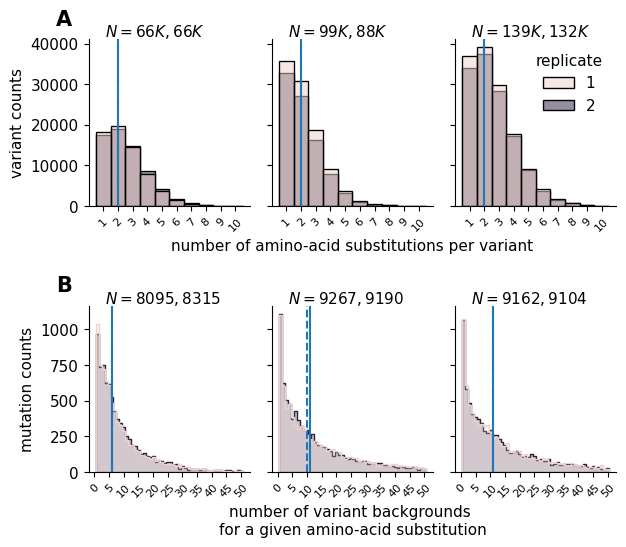

In [76]:
saveas = f"raw_data_summary_barcodes_backgrounds_hist"
logscale=False
fig, ax = plt.subplots(2,3, sharex="row", sharey="row", figsize=[6.4, 5.5])

condition_title = {
    "Delta":"Delta",
    "Omicron_BA1" : "BA.1",
    "Omicron_BA2" : "BA.2"
}

row = 0
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    iter_ax = ax[row, col]
    
    df = condition_df.query("aa_substitutions != ''")
    df = df.assign(
        num_muts = [
            len(aa_subs.split())
            for aa_subs in df.aa_substitutions
        ]
    )
    
    sns.histplot(df.query("num_muts <= 10"), x="num_muts", ax=iter_ax, hue="replicate", discrete=True)
    for rep, rep_df in df.groupby("replicate"):
        median = rep_df['num_muts'].median()
        iter_ax.axvline(median, linestyle=("-" if rep == 1 else "--"))
    
    if logscale: iter_ax.set_yscale('log')
    if col != 2: 
        iter_ax.get_legend().remove()
    n_rep1 = len(df.query("replicate == 1"))//1000
    n_rep2 = len(df.query("replicate == 2"))//1000
    iter_ax.text(
        0.1, 1.1, 
        f"$N={n_rep1}K, {n_rep2}K$", 
        ha="left", va="top", 
        transform=iter_ax.transAxes
    )
    xscale = "number of amino-acid substitutions per variant" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = f"variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    iter_ax.set_xticks(
        [i+1 for i in range(10)],
        labels=[i+1 for i in range(10)], 
        ha="center",
        size=8,
        rotation=45
    )
    sns.despine(ax=iter_ax)

row = 1
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[row, col]
    df = pd.DataFrame()
    for rep, rep_df in condition_df.groupby("replicate"):
        
        times_seen = (
            rep_df["aa_substitutions"].str.split().explode().value_counts()
        )
        if (times_seen == times_seen.astype(int)).all():
            times_seen = times_seen.astype(int)
        times_seen = pd.DataFrame(times_seen)
        times_seen.index.name = f"mutation"
        df = pd.concat([df, times_seen.assign(replicate=rep).reset_index()])

    sns.histplot(
        df.query("count <= 50"), 
        x="count", 
        ax=iter_ax, 
        element='step', 
        hue="replicate", 
        discrete=True
    )
    
    for rep, rep_df in df.groupby("replicate"):
        median = rep_df['count'].median()
        iter_ax.axvline(median, linestyle=("-" if rep == 1 else "--"))
        
    iter_ax.get_legend().remove()
    n_rep1 = len(df.query("replicate == 1"))
    n_rep2 = len(df.query("replicate == 2"))
    iter_ax.text(
        0.1, 1.1, 
        f"$N={n_rep1}, {n_rep2}$", 
        ha="left", va="top", 
        transform=iter_ax.transAxes
    )
    
    xscale = "number of variant backgrounds \nfor a given amino-acid substitution" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = f"mutation counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    
    xticks = [i for i in range(0, 51) if i % 5 == 0]
    iter_ax.set_xticks(
        xticks,
        labels=xticks, 
        ha="center",
        size=8,
        rotation=45
    )
    
    sns.despine(ax=iter_ax)

plt.tight_layout()

ax[0,0].text(
    -0.1, 1.06, 
    f"A", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.06, 
    f"B", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)

fig.subplots_adjust(hspace=.6)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Correlation of Replicate Functional Scores

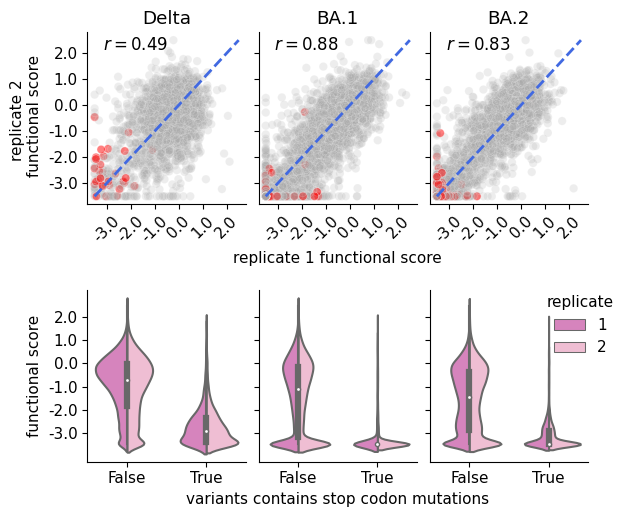

In [77]:
# move rug plot = 
# https://stackoverflow.com/questions/55066869/matplotlib-seaborn-how-to-plot-a-rugplot-on-the-top-edge-of-x-axis
# distributions


saveas = "replicate_functional_score_correlation_scatter"
pal = sns.color_palette('tab20')

fig, ax = plt.subplots(2,3, sharex="row", sharey="row", figsize=[6.4, 5.3])
# fig, ax = plt.subplots(1, 3, sharex="row", sharey="row", figsize=[6.4, 3])
# fig, ax = plt.subplots(3, sharex="row", sharey="row", figsize=[6.4, 6])
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
collapsed_bc_df = collapsed_bc_df.assign(
    is_stop=[True if "*" in aasubs else False for aasubs in collapsed_bc_df.aa_substitutions]
)

is_stop_alpha_dict = {
    True : 0.5,
    False : 0.2
}



# row1 = [f"corr_{con}" for con in collapsed_bc_df.groupby("condition")]
# row2 = [f""]


lim = [-3.8, 2.8]
ticks = np.linspace(-3, 2, 6)
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    
    row = 0
    iter_ax = ax[row, col]
#     row = 0
#     iter_ax = ax[col]
    
    df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        [
            rep_df.rename({"func_score":f"rep_{rep}_func_score"}, axis=1).set_index("aa_substitutions")
            for rep, rep_df in condition_df.groupby("replicate") 
        ],
    )
    
    df = df.assign(
        is_stop=[True if "*" in aasubs else False for aasubs in df.index.values]
    )
    alpha = [is_stop_alpha_dict[istp] for istp in df.is_stop]
    sns.scatterplot(
        df, 
        x="rep_1_func_score", 
        y="rep_2_func_score", 
        ax =iter_ax,
        alpha=alpha,
#         c='0.25',
        hue="is_stop",
        hue_order=[False, True],
        palette=["darkgrey", "red"]
    )
    
    
# #     g.plot_marginals(sns.boxplot)
#     sns.rugplot(
#         df.query("not is_stop"), 
#         x="rep_1_func_score", 
#         y="rep_2_func_score", 
#         ax =iter_ax,
#         alpha=0.01,
#         c='grey',
#         lw=2,
#         height=.03, 
#         clip_on=False,
# #         hue="is_stop",
# #         hue_order=[False, True],
# #         palette=["k", "red"]
        
#     )
#     sns.rugplot(
#         df.query("is_stop"), 
#         x="rep_1_func_score", 
#         y="rep_2_func_score", 
#         ax =iter_ax,
#         alpha=0.2,
#         c='red',
#         lw=1,
#         height=-.03, 
#         clip_on=False,
# #         hue="is_stop",
# #         hue_order=[False, True],
# #         palette=["k", "red"]
        
#     )




    iter_ax.plot([-3.5, 2.5], [-3.5, 2.5], "--", lw=2, c="royalblue")
    
    iter_ax.set_ylim(lim)
    iter_ax.set_xlim(lim)
    if col == 0:
        iter_ax.set_yticks(ticks, labels=ticks)
    iter_ax.set_xticks(ticks, labels=ticks, rotation=45)
    
    corr = pearsonr(df["rep_1_func_score"], df["rep_2_func_score"])[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=12
    )
    iter_ax.set_title(condition)
#     iter_ax.grid()
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    row = 1
    iter_ax = ax[row, col]
    sns.violinplot(
        condition_df,
        x="is_stop",
        y="func_score",
        hue="replicate",
        split=True,
        palette=pal.as_hex()[12:14],
        ax=iter_ax
    )
    
    sns.despine(ax=iter_ax)
    
    
#     sns.histplot(
#         condition_df, 
#         x="func_score", 
#         ax=iter_ax, 
# #         element='step', 
#         hue="replicate", 
# #         discrete=True
#         kde=True
#     )
    if col != 2:
        iter_ax.get_legend().remove()
    else:
        iter_ax.legend(bbox_to_anchor = (1.25, 1.05), title="replicate")
    if col == 0:
        iter_ax.set_yticks(ticks, labels=ticks)
        
# ax[0].set_xlabel("")
# ax[0].set_ylabel("replicate 2 \n functional Scores")

# ax[1].set_xlabel("replicate 1 functional scores")
# ax[1].set_title("BA.1")
# ax[2].set_xlabel("")
# ax[2].set_title("BA.2")

ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("replicate 2 \n functional score")

ax[0,1].set_xlabel("replicate 1 functional score")
ax[0,1].set_title("BA.1")
ax[0,2].set_xlabel("")
ax[0,2].set_title("BA.2")

ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("functional score")

ax[1,1].set_xlabel("variants contains stop codon mutations")
# ax[1,1].set_title("BA.1")
ax[1,2].set_xlabel("")
ax[1,2].set_ylabel("")
ax[1,1].set_ylabel("")
# ax[1,2].set_title("BA.2")

# fig.suptitle("Variant Functional Score \nReplicate Correlation")
plt.tight_layout()
fig.subplots_adjust(wspace=0.08, hspace = 0.5)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Convergence Analysis

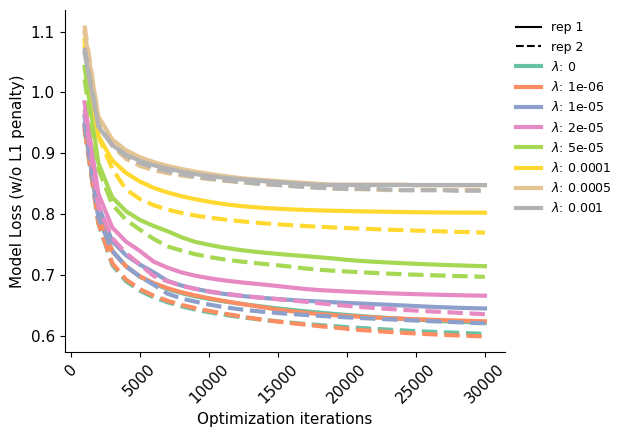

In [78]:
saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("Set2")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="-" if model_row.replicate == 0 else "--",
        label=f"rep: {model_row.replicate} λ: {model_row.λ_lasso_shift}"
    )
ax.set_xticks(ax.get_xticks()[1:-1], ax.get_xticklabels()[1:-1], rotation=45, ha='center')
ax.set_ylabel("Model Loss (w/o L1 penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda$: "+str(lasso)
    )
    for lasso, color in zip(models.λ_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)
sns.despine(ax=ax)

# fig.suptitle("Replicate Fit Convergence")
plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Shrinkage Analysis

In [79]:
tall_mut_df = pd.DataFrame()
for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {f"l_{float(row.λ_lasso_shift)}":row[model_name] for _, row in rep_models.iterrows()}
    
    
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )


    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if "_S_" in col and "avg" not in col
        ],
        value_name="S"
    )
    mut_df = mut_df.assign(
        λ_lasso=[ 
            v.split("_")[1]
            for v in mut_df.variable
        ],
        sense=[
            "stop" if "*" in mut else "non synonymous"
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[3:])
            for v in mut_df.variable
        ],
        replicate=replicate
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    tall_mut_df = pd.concat([tall_mut_df, mut_df])
    
tall_mut_df

,mutation,S,λ_lasso,sense,condition,replicate
0,M1I,0.365254,0.0,non synonymous,Delta,0
1,F2I,-0.551856,0.0,non synonymous,Delta,0
2,F2L,-0.133367,0.0,non synonymous,Delta,0
3,F2S,0.186726,0.0,non synonymous,Delta,0
4,F2V,-1.471370,0.0,non synonymous,Delta,0
...,...,...,...,...,...,...
103611,S1252T,-0.000000,0.001,non synonymous,Omicron_BA2,1
103612,S1252V,-0.000000,0.001,non synonymous,Omicron_BA2,1
103613,S1252W,-0.000000,0.001,non synonymous,Omicron_BA2,1
103614,S1252Y,-0.000000,0.001,non synonymous,Omicron_BA2,1


In [80]:
def loss(model, condition):
    kwargs = {
        'λ_ridge_beta': 0.,
        'λ_ridge_shift': 0.,
        'λ_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("λ_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "stop" if "*" in mut else "non synonymous"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    
    # plot corr by sparsity
    for cond in model.data.conditions:
        if cond == model.data.reference: continue
        if np.all(muts_df_inner[f"0_S_{cond}"] <= 0.05) or np.all(muts_df_inner[f"1_S_{cond}"] <= 0.05):
            lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
            lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(np.nan)
        else:
            corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])
            r = corr[0]
            interval = corr.confidence_interval()
            lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)
            lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(
                tuple[(interval.low, interval.high)]
            )
        
        for rep, marker in zip([0,1], ["o", "D"]):
            rep_cond_shifts = muts_df_outer[[f"{rep}_S_{cond}", "sense"]].dropna()
            for sense, color in zip(["stop", "non synonymous"], ["red", "blue"]):
                shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_S_{cond}"]
                sparsity = len(shifts[shifts==0]) / len(shifts)
                lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            
    # plot loss 
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        rep = row.replicate
        for cond in model.data.conditions:
            if cond == model.data.reference: continue
            lasso_sparsity_loss[f"{cond}-{rep}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

,lasso,Delta-replicate-correlation,Delta-replicate-correlation-interval,Delta-0-stop-sparsity,Delta-0-non synonymous-sparsity,Delta-1-stop-sparsity,Delta-1-non synonymous-sparsity,Omicron_BA2-replicate-correlation,Omicron_BA2-replicate-correlation-interval,Omicron_BA2-0-stop-sparsity,Omicron_BA2-0-non synonymous-sparsity,Omicron_BA2-1-stop-sparsity,Omicron_BA2-1-non synonymous-sparsity,Delta-0-loss,Omicron_BA2-0-loss,Delta-1-loss,Omicron_BA2-1-loss
0,0.0,0.550706,"tuple[0.5327558001438703, 0.568161329620449]",0.000000,0.000000,0.000000,0.000000,0.626114,"tuple[0.6104194327667188, 0.641317137901075]",0.000000,0.000000,0.000000,0.000000,0.2087812698808719,0.1867393006161542,0.24558407543928598,0.17621512274569837
1,1e-06,0.569073,"tuple[0.5516440307110266, 0.5860048816396765]",0.010582,0.011265,0.018868,0.015645,0.614877,"tuple[0.598827218641175, 0.6304333205571957]",0.031746,0.021403,0.042453,0.025223,0.20968838484828134,0.1875596507683098,0.245362417728046,0.17615023123915105
2,1e-05,0.643579,"tuple[0.6284502611894246, 0.6582214322982628]",0.423280,0.145961,0.344340,0.145594,0.625655,"tuple[0.6099453114071763, 0.6408722337022443]",0.539683,0.224976,0.533019,0.207056,0.21728593425845505,0.1946640510742787,0.2570902114259448,0.18425789002783124
3,2e-05,0.665407,"tuple[0.6510077922406747, 0.6793274202163707]",0.777778,0.250241,0.641509,0.257822,0.681500,"tuple[0.6676554046628856, 0.6948737938541736]",0.867725,0.391696,0.896226,0.360153,0.22450889632568466,0.20096912521039875,0.26543152623553207,0.18841946812710644
4,5e-05,0.699546,"tuple[0.6863391633486625, 0.7122913765582897]",0.978836,0.483907,0.962264,0.493295,0.744132,"tuple[0.7325769740124719, 0.7552587141753088]",0.994709,0.644030,0.995283,0.616220,0.24224307111134985,0.21271545188582364,0.28434654136265564,0.19949324054447795
5,0.0001,0.676946,"tuple[0.6629427653242231, 0.6904754754536244]",1.000000,0.906984,1.000000,0.829342,0.755060,"tuple[0.7439262761110392, 0.7657755470376886]",1.000000,0.932893,1.000000,0.876756,0.2761963692839128,0.2307141231323999,0.3111371143886215,0.2155335190605666
6,0.0005,NaN,NaN,1.000000,1.000000,1.000000,0.999840,NaN,NaN,1.000000,0.999839,1.000000,0.999840,0.2955295555366075,0.24429836439257377,0.3358935518271298,0.23729005809168738
7,0.001,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,0.29580652304326244,0.2443851190766541,0.33547136586106335,0.23737351025200742


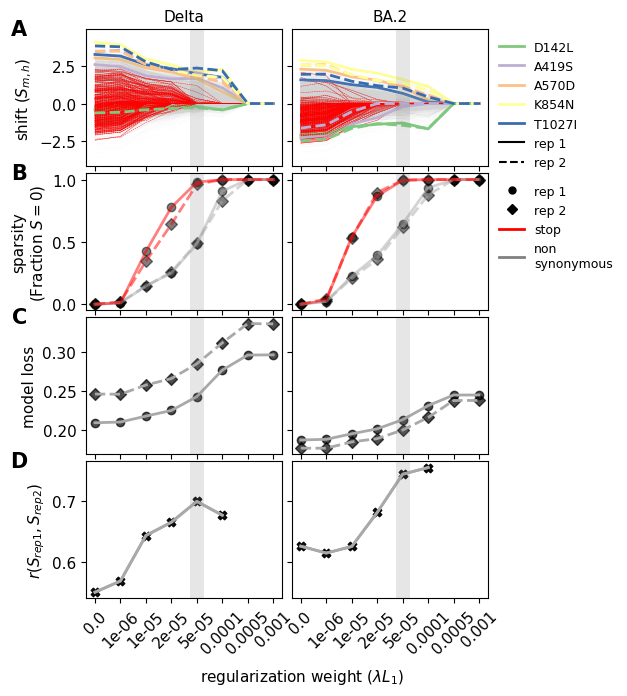

In [81]:
# call percent - > "fraction"
# Change lambda to whatever we decide for the lexicon

saveas="shrinkage_analysis_trace_plots"
fig, ax = plt.subplots(4,2, figsize=[6.4,7],sharex=True, sharey='row')

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.λ_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "non synonymous" : "darkgrey",
    "stop" : "red"
}

sense_lw = {
    "non synonymous" : 0.5,
    "stop" : 0.3
}

sense_alpha = {
    "non synonymous" : 0.1,
    "stop" : 1.0
}

model_choice = 5e-5
model_line_kwargs = {
    "linewidth" : 10,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    
    # plot non synonymous, non validated
    for mut, trace_df in df.query(
        "sense == 'non synonymous' & not mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_alpha['non synonymous'],
            alpha=sense_alpha['non synonymous'],
            color="lightgrey"
        )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'stop'").groupby("mutation"):

        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['stop'],
            alpha=sense_alpha['stop'],
            color=sense_colors['stop']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    for sense in ["non synonymous", "stop"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
    # Plot Correlation  
    row = 3
    iter_ax = ax[row, condition_col[condition]]
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        linestyle="-",
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )
    
    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        marker="X",
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)

ax[0, 0].set_title("Delta", size=11)
ax[0, 1].set_title("BA.2", size=11)

ax[0, 0].set_ylabel("shift $(S_{m,h})$", size=11)
ax[1, 0].set_ylabel("sparsity\n(Fraction $S = 0$)", size=11)
ax[2, 0].set_ylabel("model loss", size=11)
ax[3, 0].set_ylabel("$r(S_{rep1},S_{rep2})$", size=11)


# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
ax[0,1].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='non\nsynonymous')

elements = [black_circle, black_triangle, red_line, grey_line] #+lasso_color_handles
ax[1, 1].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

ax[3,0].set_xticks(ax[3,0].get_xticks(), ax[3,0].get_xticklabels(), rotation=45, ha='center')
ax[3,1].set_xticks(ax[3,1].get_xticks(), ax[3,1].get_xticklabels(), rotation=45, ha='center')

ax[3,0].set_xlabel(f"regularization weight ($\lambda L_{1}$)")
ax[3,0].xaxis.set_label_coords(1.1, -.5)

plt.tight_layout()




fig.subplots_adjust(hspace=0.05, wspace=0.05)


ax[0,0].text(
    -0.3, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.3, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)
ax[2,0].text(
    -0.3, 1.00, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[2,0].transAxes
)
ax[3,0].text(
    -0.3, 1.00, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[3,0].transAxes
)


fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Global Epistasis Fits

In [82]:
chosen_replicate_models = models.query("λ_lasso_shift == 5e-5")
replicate_data = {}
for row_idx, replicate_row in chosen_replicate_models.iterrows():    
     
    model = replicate_row[model_name]
    df = model.variants_df
    xlb, xub = [-1, 1] + np.quantile(df.predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(df.corrected_func_score, [0.05, 1.0])
    additive_model_grid = np.linspace(xlb, xub, num=1000)
    params = model.get_condition_params(model.data.reference)
    latent_preds = model._model_components["g"](params["α"], additive_model_grid)
    shape = (additive_model_grid, latent_preds)   
    
    replicate_data[replicate_row.replicate] = {
        "variants_df" : df,
        "wildtype_df" : model.wildtype_df,
        "epistasis_shape" : shape,
        "condition_colors" : model.data.condition_colors
    }

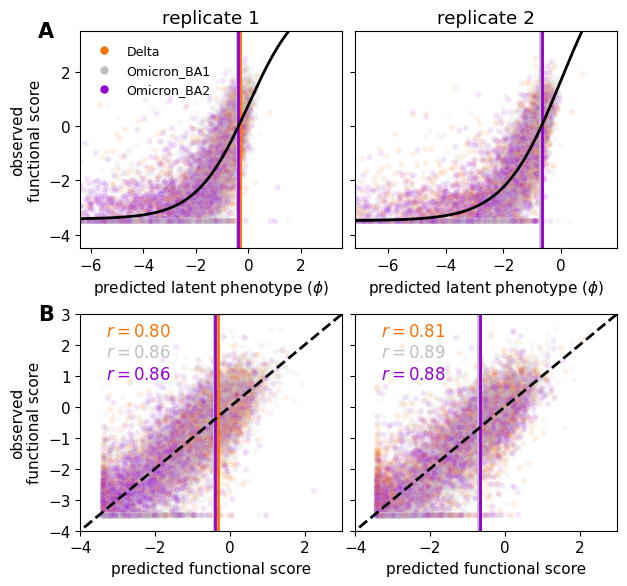

In [83]:
saveas="global_epistasis_and_prediction_correlations"
fig, ax = plt.subplots(2,2, figsize=[6.4,6], sharey='row')    

row=0
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.1),
        x="predicted_latent",
        y=f"corrected_func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1,
        lw=3
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    iter_ax.plot(*data["epistasis_shape"], color="k", lw=2)
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].corrected_func_score, [0.05, 1.0])
    iter_ax.set_xlim([xlb, xub])
    iter_ax.set_ylim([ylb, yub])
    iter_ax.set_title(f"replicate {replicate+1}")
    iter_ax.set_ylabel("observed\nfunctional score")
    iter_ax.set_xlabel("predicted latent phenotype ($\phi$)")

row=1
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.1),
        x="predicted_func_score",
        y=f"corrected_func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].corrected_func_score, [0.05, 1.0])
    
    iter_ax.plot([ylb, yub], [ylb, yub], "k--", lw=2)
    iter_ax.set_xlim([-4, 3])
    iter_ax.set_ylim([-4, 3])
    iter_ax.set_ylabel("observed\nfunctional score")
    iter_ax.set_xlabel("predicted functional score")

    start_y = 0.9
    for c, cdf in data["variants_df"].groupby("condition"):
        r = pearsonr(
            cdf["predicted_func_score"],
            cdf["corrected_func_score"]
        )[0]
        iter_ax.annotate(
            f"$r = {r:.2f}$",
            (0.1, start_y),
            xycoords="axes fraction",
            fontsize=12,
            c=model.data.condition_colors[c],
        )
        start_y += -0.1


elements = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',markersize=5, label=condition)
    for condition, color in replicate_data[0]["condition_colors"].items()
]


ax[0, 0].legend(
    handles=elements, 
    bbox_to_anchor = (0., .99), 
    loc='upper left', 
    frameon=False, 
    fontsize=9
)
    
    
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)

ax[0,0].text(
    -0.1, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)


fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()


## Combined Trace and epistasis

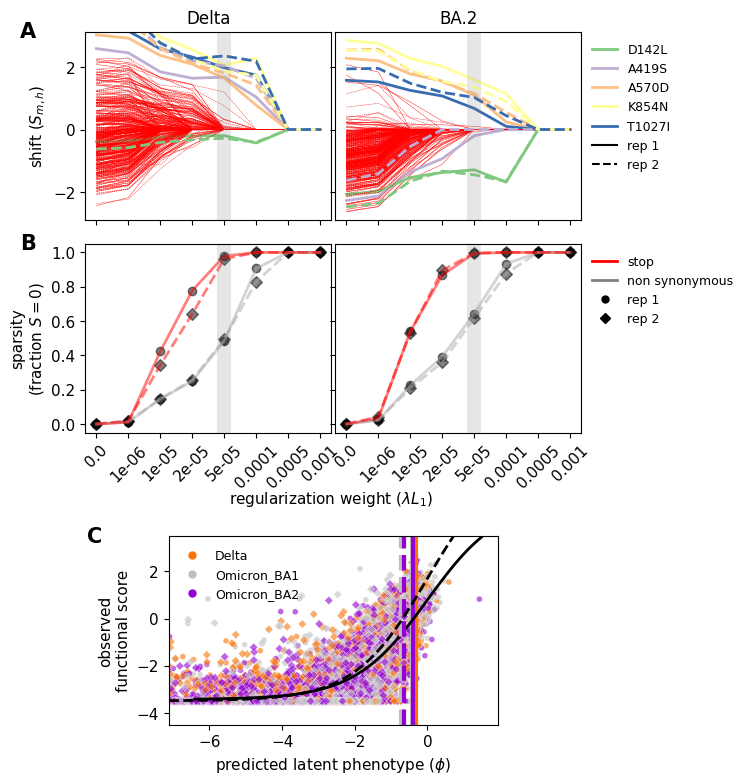

In [84]:
saveas="shrinkage_analysis_trace_plots_with_epistasis"
# fig, ax = plt.subplots(4,2, figsize=[6.4,7],sharex=True, sharey='row')

fig = plt.figure(figsize=[6.4, 9])
row1 = ["Delta_trace"]*3 + ["Omicron_BA2_trace"]*3
row2 = ["Delta_sparse"]*3 + ["Omicron_BA2_sparse"]*3
row3 = ["."]+["epistasis"]*4 + ["."]

axs = fig.subplot_mosaic(
    [
        row1,
        row2,
        ["."] * 6,
        row3
    ],
    height_ratios=[1,1,0.3,1],
#     width_ratios=width_ratios,
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.15,
    }
)

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.λ_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

# condition_col = {
#     "Delta" : 0,
#     "Omicron_BA2" : 1
# }

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "non synonymous" : "darkgrey",
    "stop" : "red"
}

sense_lw = {
    "non synonymous" : 0.5,
    "stop" : 0.3
}

sense_alpha = {
    "non synonymous" : 0.1,
    "stop" : 1.0
}

model_choice = 5e-5
model_line_kwargs = {
    "linewidth" : 10,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
#     row = 0
    iter_ax = axs[f"{condition}_trace"]
    
    # plot non synonymous, non validated
#     for mut, trace_df in df.query(
#         "sense == 'non synonymous' & not mutation.isin(@mutations_to_highlight)"
#     ).groupby("mutation"):
#         iter_ax.plot(
#             trace_df.λ_lasso, 
#             trace_df.S,
#             linestyle=replicate_line_style[replicate],
#             linewidth=sense_alpha['non synonymous'],
#             alpha=sense_alpha['non synonymous'],
#             color="lightgrey"
#         )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'stop'").groupby("mutation"):

        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['stop'],
            alpha=sense_alpha['stop'],
            color=sense_colors['stop']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.λ_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
#     iter_ax.tick_params()
    iter_ax.tick_params(axis='x', bottom=True, labelbottom=False)
    if condition == "Omicron_BA2": iter_ax.tick_params(axis='y', left=True, labelleft=False)
    
    
        
    # Plot sparsity    
#     row = 1
    iter_ax = axs[f"{condition}_sparse"]
#     iter_ax = ax[row, condition_col[condition]]
    for sense in ["non synonymous", "stop"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    iter_ax.set_xticks(iter_ax.get_xticks(), iter_ax.get_xticklabels(), rotation=45, ha='center')
    if condition == "Omicron_BA2": iter_ax.tick_params(axis='y', left=True, labelleft=False)
    
#     ax[3,1].set_xticks(iter_ax.get_xticks(), iter_ax.get_xticklabels(), rotation=45, ha='center')

for r1, r2 in zip(row1, row2):
    axs[r2].sharex(axs[r1])
    
axs["Delta_trace"].sharey(axs["Omicron_BA2_trace"])
axs["Delta_sparse"].sharey(axs["Omicron_BA2_sparse"])
axs["Delta_trace"].set_ylabel("shift $(S_{m,h})$", size=11)
axs["Delta_sparse"].set_ylabel("sparsity\n(fraction $S = 0$)", size=11)
# axs["Delta_sparse"].set_xlabel("Sparsity\n(Percent $S = 0$)", size=11)
axs["Delta_sparse"].set_xlabel(f"regularization weight ($\lambda L_{1}$)")
axs["Delta_sparse"].xaxis.set_label_coords(1.0, -.3)
axs["Delta_trace"].set_title("Delta", size=12)
axs["Omicron_BA2_trace"].set_title("BA.2", size=12)

# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
axs["Omicron_BA2_trace"].legend(handles=elements, 
                                bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='non synonymous')

elements = [red_line, grey_line, black_circle, black_triangle] #+lasso_color_handles
axs["Omicron_BA2_sparse"].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

# row=0
for replicate, data in replicate_data.items():

    iter_ax = axs["epistasis"]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.05),
        x="predicted_latent",
        y=f"corrected_func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.6,
        marker=replicate_marker[replicate]
#         lw=3
    )
    
    # WT LINES
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=3,
            linestyle=replicate_line_style[replicate],
            
        )
    
    # SHAPE OF EPISTASIS
    iter_ax.plot(
        *data["epistasis_shape"], 
        color="k", 
        lw=2,
        linestyle=replicate_line_style[replicate]
    )
    
xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
ylb, yub = [-1, 1] + np.quantile(data["variants_df"].corrected_func_score, [0.05, 1.0])
iter_ax.set_xlim([xlb, xub])
iter_ax.set_ylim([ylb, yub])
iter_ax.set_ylabel("observed\nfunctional score")
iter_ax.set_xlabel("predicted latent phenotype ($\phi$)")

elements = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',markersize=5, label=condition)
    for condition, color in replicate_data[0]["condition_colors"].items()
]


axs["epistasis"].legend(
    handles=elements, 
    bbox_to_anchor = (0., .99), 
    loc='upper left', 
    frameon=False, 
    fontsize=9
)

axs["Delta_trace"].text(
    -0.2, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta_trace"].transAxes
)
axs["Delta_sparse"].text(
    -0.2, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta_sparse"].transAxes
)
axs["epistasis"].text(
    -0.2, 1.00, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["epistasis"].transAxes
)

# plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Percent Shifts Under X

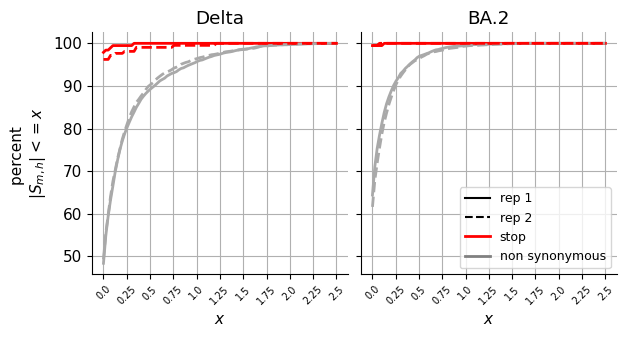

In [85]:


# separate the deletions

saveas = "percent_shifts_under_x_lineplot"
fig, ax = plt.subplots(1,2, figsize=[6.4,3.5], sharey='row')
tall_mut_df_chosen = tall_mut_df.query("λ_lasso == '5e-05'")

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

sense_colors = {
    "non synonymous" : "darkgrey",
    "stop" : "red"
}

t_points = np.linspace(0, 2.5, 100)
def perc_abs_lte(x, t):
    abs_x = np.abs(x)
    return len(abs_x[abs_x<=t]) / len(x) #)*100

for (condition, replicate, sense), df in tall_mut_df_chosen.groupby(["condition", "replicate", "sense"]):
    iter_ax = ax[condition_col[condition]]
    lt_percentages = [perc_abs_lte(df["S"], t)*100 for t in t_points]
    iter_ax.plot(
        t_points, 
        lt_percentages,
        linestyle = replicate_line_style[replicate],
        color = sense_colors[sense],
        linewidth = 2 
    )
    iter_ax.set_xticks(np.linspace(0,2.5,11),np.linspace(0,2.5,11), rotation=45, ha="center",size=7)
    sns.despine(ax=iter_ax)
    iter_ax.grid(visible=True)
    
ax[condition_col["Delta"]].set_title("Delta")
ax[condition_col["Omicron_BA2"]].set_title("BA.2")

ax[0].set_ylabel("percent \n$|S_{m,h}| <= x$")
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='non synonymous')
ax[1].legend(
    handles=[black_line, black_dashed, red_line, grey_line], 
    bbox_to_anchor = (1, 0), 
    loc='lower right', 
    frameon=True, 
    fontsize=9
)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Correlation of BA2 and Delta Shifts

In [86]:
chosen_replicate_models = models.query("λ_lasso_shift == 5e-5")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=1,
    how="inner"
)
mut_df_replicates

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_Omicron_BA2,1_S_Omicron_BA2,avg_S_Omicron_BA2
mutation,,,,,,,,,,,,
M1I,M,1,I,-2.975049,-3.927958,-3.451503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F2L,F,2,L,0.186080,0.210534,0.198307,-0.000000,-0.000000,0.000000,-0.201996,0.000000,-0.100998
F2S,F,2,S,0.188163,-0.071015,0.058574,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
F2V,F,2,V,0.219565,-0.059422,0.080071,-0.000000,-0.002961,-0.001481,0.000000,0.000000,0.000000
V3A,V,3,A,-0.016013,-0.042291,-0.029152,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
S1252T,S,1252,T,-0.136357,-0.188409,-0.162383,-0.000000,0.000000,0.000000,-0.060079,-0.000000,-0.030040
S1252V,S,1252,V,0.157162,0.178422,0.167792,0.257386,-0.183734,0.036826,-0.036923,-0.110835,-0.073879
S1252W,S,1252,W,0.103983,0.263182,0.183582,0.000000,0.000000,0.000000,0.000000,-0.023344,-0.011672


In [87]:
chosen_replicate_models = models.query("λ_lasso_shift == 5e-5")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="outer"
)
mut_df_replicates["sense"] = [
    "stop" if mut == "*" else "non synonymous" for mut in mut_df_replicates.muts
]

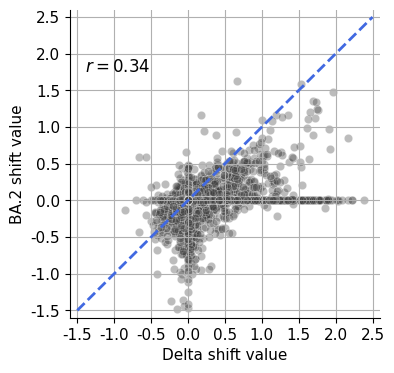

In [88]:
data = mut_df_replicates.dropna()
saveas="shift_corr_Delta_BA2"
fig, ax = plt.subplots(1,figsize=[4,4])
lim = [-1.6, 2.6]
ticks = np.linspace(-1.5, 2.5, 9)
sns.scatterplot(
    data=data,
    x="avg_S_Delta",
    y="avg_S_Omicron_BA2",
#     hue = "sense",
    alpha = 0.35,
    ax=ax,
    c='0.25'
)
ax.plot()
ax.plot(
    [-1.5, 2.5], 
    [-1.5, 2.5],
    linestyle="--", 
    lw=2,
    c='royalblue'
)
corr = pearsonr(data["avg_S_Delta"], data["avg_S_Omicron_BA2"])[0]
ax.annotate(
    f"$r = {corr:.2f}$", 
    (0.05, 0.8), 
    xycoords="axes fraction", 
    fontsize=12
)
ax.set_ylim(lim)
ax.set_xlim(lim)
ax.set_yticks(ticks, labels=ticks)
ax.set_xticks(ticks, labels=ticks)
ax.set_ylabel("BA.2 shift value")
ax.set_xlabel("Delta shift value")
# ax.set(xticks=np.linspace(-1.5, 2.5, 5))
ax.grid()
sns.despine(ax=ax)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

Note that we're plotting the average. that's why less correlation between delta shifts makes the density of stop so much smaller for Delta

## Comparison to Naive approach

In [89]:
naive_model_set = "../results/naive_approach/"
naive_models = pickle.load(open(f"{naive_model_set}/models.pkl", "rb"))
naive_models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,λ_ridge_ch,data_idx,epistatic_model,output_activation,...,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_3000,replicate,condition
0,<multidms.data.MultiDmsData object at 0x7fbe57...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.31203029678950295, 0.23625210580935888, 0.2...",<multidms.model.MultiDmsModel object at 0x7fbe...,0,Delta
3,<multidms.data.MultiDmsData object at 0x7fbe57...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.2948697926675047, 0.25160339956684513, 0.24...",<multidms.model.MultiDmsModel object at 0x7fc1...,1,Delta
1,<multidms.data.MultiDmsData object at 0x7fbe56...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.24738580498232596, 0.22392991691351716, 0.2...",<multidms.model.MultiDmsModel object at 0x7fbe...,0,Omicron_BA1
4,<multidms.data.MultiDmsData object at 0x7fbe56...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.2016639589109823, 0.1772295498722254, 0.172...",<multidms.model.MultiDmsModel object at 0x7fbe...,1,Omicron_BA1
2,<multidms.data.MultiDmsData object at 0x7fbe55...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.2159512679704268, 0.19288537791487242, 0.18...",<multidms.model.MultiDmsModel object at 0x7fbe...,0,Omicron_BA2
5,<multidms.data.MultiDmsData object at 0x7fbe55...,1,0.00002,0,0,0,0,0,Sigmoid,Identity,...,False,0.000001,3,1000,[3000],0,"[0.20598509065865622, 0.18326607028080533, 0.1...",<multidms.model.MultiDmsModel object at 0x7fbe...,1,Omicron_BA2


In [90]:
fit_dict = {f"{row.replicate}-{row.condition}":row.model_3000 for _, row in naive_models.iterrows()}
mut_df = multidms.utils.combine_replicate_muts(fit_dict,how="inner",times_seen_threshold=3)
mut_df

,wts,sites,muts,0-Delta_β,1-Delta_β,0-Omicron_BA1_β,1-Omicron_BA1_β,0-Omicron_BA2_β,1-Omicron_BA2_β,avg_β
mutation,,,,,,,,,,
M1I,M,1,I,-2.509346,-5.183149,-4.717206,-5.249604,-5.010637,-6.347744,-4.836281
F2L,F,2,L,0.695470,1.095539,0.402694,0.673661,-0.385884,0.429805,0.485214
V3A,V,3,A,0.110519,-0.024772,0.084359,0.028171,-0.054072,-0.113430,0.005129
V3F,V,3,F,-0.621172,0.185542,-0.675041,-0.548449,-0.635997,-0.430014,-0.454189
V3G,V,3,G,-0.314578,0.897483,0.006068,0.131336,0.077659,0.049073,0.141174
...,...,...,...,...,...,...,...,...,...,...
S1252R,S,1252,R,0.974202,0.386746,0.232415,0.573367,0.592692,0.625938,0.564227
S1252T,S,1252,T,-0.248973,-0.714395,-0.243054,-0.347725,-0.571046,-0.539059,-0.444042
S1252V,S,1252,V,0.444267,0.068158,0.370209,0.550719,0.312138,0.208330,0.325637


In [91]:
reference = "Omicron_BA1"
for i, condition in enumerate(["Delta", "Omicron_BA2"]): 
    for replicate in [0, 1]:
        reference_betas = mut_df[f"{replicate}-{reference}_β"]
        condition_betas = mut_df[f"{replicate}-{condition}_β"]
        mut_df[f"{replicate}-{condition}_S"] = condition_betas - reference_betas
mut_df

,wts,sites,muts,0-Delta_β,1-Delta_β,0-Omicron_BA1_β,1-Omicron_BA1_β,0-Omicron_BA2_β,1-Omicron_BA2_β,avg_β,0-Delta_S,1-Delta_S,0-Omicron_BA2_S,1-Omicron_BA2_S
mutation,,,,,,,,,,,,,,
M1I,M,1,I,-2.509346,-5.183149,-4.717206,-5.249604,-5.010637,-6.347744,-4.836281,2.207859,0.066455,-0.293432,-1.098140
F2L,F,2,L,0.695470,1.095539,0.402694,0.673661,-0.385884,0.429805,0.485214,0.292775,0.421879,-0.788579,-0.243856
V3A,V,3,A,0.110519,-0.024772,0.084359,0.028171,-0.054072,-0.113430,0.005129,0.026161,-0.052943,-0.138430,-0.141601
V3F,V,3,F,-0.621172,0.185542,-0.675041,-0.548449,-0.635997,-0.430014,-0.454189,0.053870,0.733991,0.039044,0.118434
V3G,V,3,G,-0.314578,0.897483,0.006068,0.131336,0.077659,0.049073,0.141174,-0.320647,0.766147,0.071591,-0.082263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S1252R,S,1252,R,0.974202,0.386746,0.232415,0.573367,0.592692,0.625938,0.564227,0.741787,-0.186620,0.360278,0.052571
S1252T,S,1252,T,-0.248973,-0.714395,-0.243054,-0.347725,-0.571046,-0.539059,-0.444042,-0.005918,-0.366670,-0.327992,-0.191334
S1252V,S,1252,V,0.444267,0.068158,0.370209,0.550719,0.312138,0.208330,0.325637,0.074058,-0.482561,-0.058071,-0.342390


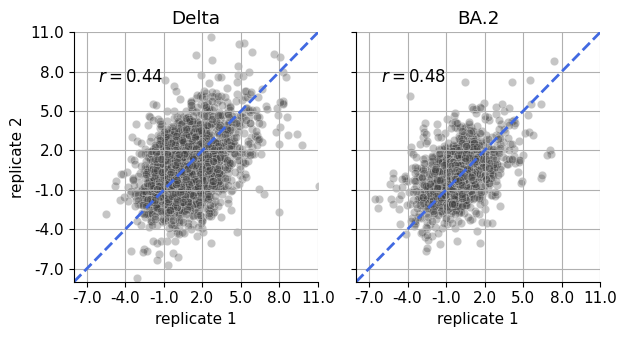

In [92]:
saveas = "naive_approach_replicate_shifts_correlation"

fig, ax = plt.subplots(1,2, figsize=[6.4,3.5], sharex=True, sharey=True)
lim = [-8, 11]
ticks = np.linspace(-7, 11, 7)
for i, condition in enumerate(["Delta", "Omicron_BA2"]):
    iter_ax = ax[i]
    sns.scatterplot(
        mut_df, 
        x=f"0-{condition}_S", 
        y=f"1-{condition}_S", 
        ax=iter_ax,
        alpha=0.3,
        c='0.25'
    )
    iter_ax.set_ylim(lim)
    iter_ax.set_xlim(lim)
    iter_ax.set_xticks(ticks, labels=ticks)
    iter_ax.set_yticks(ticks, labels=ticks)
    iter_ax.plot([-8, 12], [-8, 12], "--", lw=2, c="royalblue")
    
    corr = pearsonr(mut_df[f"0-{condition}_S"], mut_df[f"1-{condition}_S"])[0]
#     sns.scatterplot(mut_df, x=f"0-{condition}_S", y=f"1-{condition}_S", ax=ax[i], alpha=0.25)
    ax[i].annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.8), 
        xycoords="axes fraction", 
        fontsize=12
    )
    iter_ax.grid()
    sns.despine(ax=iter_ax)
    
    
ax[0].set_title("Delta")
ax[0].set_xlabel("replicate 1")
ax[0].set_ylabel("replicate 2")
ax[1].set_title("BA.2")
ax[1].set_xlabel("replicate 1")

plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Betas and Shifts (Distributions and Correlations)

histogram vmax: 30


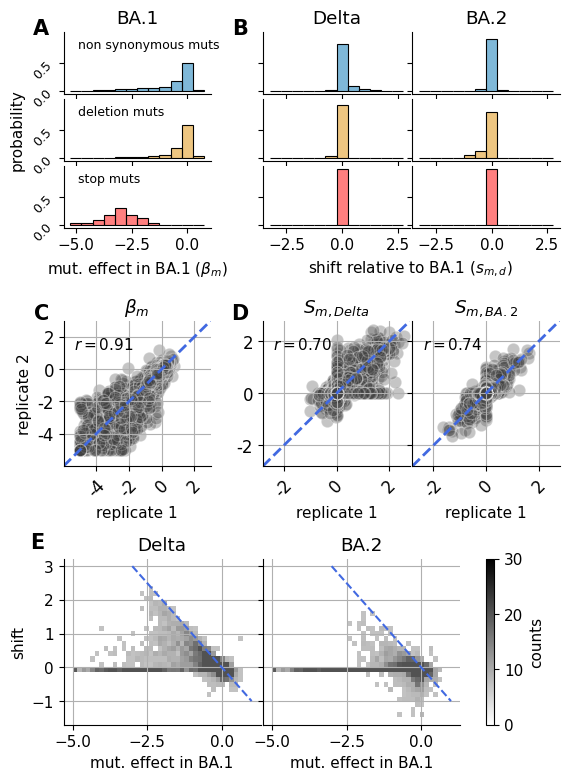

In [106]:
# data = mut_df_replicates.copy()
saveas="shift_distribution_correlation_effect"
pal = sns.color_palette('colorblind')
fig = plt.figure(figsize=[6.4, 9])

# the ratio of plot to divider between 
dist_sf = 3

# three rows of distributions
dist_rows = [[] for _ in range(3)]
for row, mut_type in enumerate(["m", "i", "n"]):
    dist_rows[row].extend([f"dist_{mut_type}_β"]*dist_sf)
    dist_rows[row].append(".")
    for param in ["S_Delta", "S_Omicron_BA2"]:
        dist_rows[row].extend([f"dist_{mut_type}_{param}"]*dist_sf)

# empty space row
number_of_rows = len(dist_rows[0])
empty_row = ["."] * len(dist_rows[0])

# correlation plot row
corr_row = ["corr_β"]*dist_sf+ ["."]
for param in ["S_Delta", "S_Omicron_BA2"]:
    corr_row.extend([f"corr_{param}"]*dist_sf)

# shift and effect plot
se_row_wc = ["se_S_Delta"]*4  + ["se_S_Omicron_BA2"]*4 + ["cbar"] + ["."]

axs = fig.subplot_mosaic(
    dist_rows+[empty_row, corr_row, empty_row, se_row_wc],
    height_ratios=[0.3, 0.3, 0.3] + [0.4, 0.7, 0.4, 0.8],
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.05,
    }
)

query_dict = {
    "m" : "muts != '*' and muts != '-'",
    "i" : "muts == '-'",
    "n" : "muts == '*'"
}

bins_dict = {
    "β" : np.arange(-5.25, 1.0, 0.5),
    "S_Delta" : np.arange(-3.25, 3.25, 0.5),
    "S_Omicron_BA2" : np.arange(-3.25, 3.25, 0.5)
}

#################
# DISTRIBUTIONS
#################

prefix = "avg"
bins = np.arange(-5.25, 1.0, 0.5)
df = mut_df_replicates.copy()
df["avg_β"].clip(lower=-5, inplace=True)

for col, param in enumerate(["β", "S_Delta", "S_Omicron_BA2"]):
    for row, mut_type in enumerate(["m", "i", "n"]):
        
        iter_ax = axs[f"dist_{mut_type}_{param}"]
        sns.histplot(
            df.query(query_dict[mut_type]), 
            x=f"{prefix}_{param}", 
            ax=iter_ax,
            stat='probability',
            bins=bins_dict[param],
            label="stop",
            color="red" if mut_type == "n" else pal.as_hex()[row],
#             color="lightgrey",
            alpha=0.5
        )
        iter_ax.set_ylim(-0.05,1.05)
        
        # remove the ylabel from all but the first column
        if col != 0: 
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_yticks(
            [0.0, 0.5], [0.0, 0.5], rotation=45, ha="right",size=9
        )
#         else:
#             iter_ax.set_yticks(
#                 [0.0, 0.5], [0.0, 0.5], rotation=45, ha="right",size=9
#             )
            
        if col != 0 or row != 1:
            iter_ax.set_ylabel(None)
        else:
            iter_ax.set_ylabel("probability")
        
        # remove the x labels from all but bottom
        if row != 2:
            iter_ax.tick_params(axis='x', labelbottom=False)
            iter_ax.set_xlabel(None)

        iter_ax.set_xlabel(None)
        
        sns.despine(ax=iter_ax)
        
# axs[].set_title("")
axs["dist_n_β"].set_xlabel(r"mut. effect in BA.1 ($\beta_m$)")
axs["dist_n_β"].xaxis.set_label_coords(0.5, -.5)


axs["dist_m_β"].text(
    0.1, 0.9, 
    f"non synonymous muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_m_β"].transAxes
)
axs["dist_i_β"].text(
    0.1, 0.9, 
    f"deletion muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_i_β"].transAxes
)
axs["dist_n_β"].text(
    0.1, 0.9, 
    f"stop muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_n_β"].transAxes
)

axs["dist_n_S_Delta"].set_xlabel('shift relative to BA.1 ($s_{m,d}$)')
axs["dist_n_S_Delta"].xaxis.set_label_coords(1.0, -.5)

axs["dist_m_S_Delta"].set_title("Delta")
axs["dist_m_S_Omicron_BA2"].set_title("BA.2")


#################
# CORRELATIONS
#################

data = mut_df_replicates.dropna().copy()
data['0_β'].clip(lower=-5, inplace=True)
data['1_β'].clip(lower=-5, inplace=True)
# plot the correlations of parameters
for col, param in enumerate(["β", "S_Delta", "S_Omicron_BA2"]):
    iter_ax = axs[f"corr_{param}"]
    x, y = data[f"0_{param}"], data[f"1_{param}"]
    sns.scatterplot(
        data = data,
        x = f"0_{param}",
        y = f"1_{param}",
        ax=iter_ax,
        s=80, 
        alpha=0.3,     
        c='0.25'
    )
    
    # remove y labels from all but first column
    if col != 0: 
        
        if col == 2:
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_ylabel(None)
        
        lim = [-2.8, 2.8]
        ticks = [-2, 0, 2]
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=45, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
    else:
        lim = [-6, 3]
        ticks = [-4, -2, 0, 2]
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=45, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
        iter_ax.set_ylabel("replicate 2")
        
    iter_ax.set_xlabel("replicate 1")
    iter_ax.grid()

    
    corr = pearsonr(x, y)[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.07, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    sns.despine(ax=iter_ax)


#################
# SHIFT & EFFECT
#################   


# Define variables to plot
mut_effect_var = 'avg_β'
lower_clip = -5
shift_delta_var = "avg_S_Delta"
shift_ba2_var = "avg_S_Omicron_BA2"


# Get data and clip betas
# data = mut_df.copy()
data = mut_df_replicates.dropna().copy()

# print('Subsetting to mutations with multidms data')
# data = data[data['β'].notnull()]
data[mut_effect_var].clip(lower=lower_clip, upper=1, inplace=True)
data[shift_delta_var].clip(lower=-2.5, upper=3.1, inplace=True)
data[shift_ba2_var].clip(lower=-2.5, upper=3.1, inplace=True)

# Compute a statistic of shifts as a function of betas
# stat_dict = {
#     key : []
#     for key in [mut_effect_var, 'metric_BA2', 'metric_Delta']
# }
# half_window_size = 0.25
# for beta in np.arange(lower_clip, 0.5, 0.1):
#     data_i = data[data[mut_effect_var].between(beta-half_window_size, beta+half_window_size)]
#     if len(data_i) < 20:
#         continue
#     stat_dict[mut_effect_var].append(beta)
#     stat_dict['metric_Delta'].append(data_i[shift_delta_var].median())
#     stat_dict['metric_BA2'].append(data_i[shift_ba2_var].median())
    
# stat_df = pd.DataFrame(stat_dict)


# Plot 2D histograms
bin_size = 0.15
min_beta = data[mut_effect_var].min()
max_beta = data[mut_effect_var].max()
beta_bins = np.arange(min_beta, max_beta+bin_size, bin_size)
min_shift = data[[shift_delta_var, shift_ba2_var]].min().min()
max_shift = data[[shift_delta_var, shift_ba2_var]].max().max()
shift_bins = np.arange(min_shift, max_shift+bin_size, bin_size)
vmax = 30
print(f'histogram vmax: {vmax}')

# Delta Heatmap
iter_ax = axs["se_S_Delta"]
sns.histplot(
    x=mut_effect_var, y=shift_delta_var, data=data,
    bins=[beta_bins, shift_bins], vmax=vmax, ax=iter_ax,
    color='k', cbar=False
)
# sns.lineplot(
#     x=mut_effect_var, y='metric_Delta', data=stat_df,
#     ax=iter_ax, color='firebrick'
# )
iter_ax.plot([-3.0,1.0], [3.0,-1.0], ls='--', c='royalblue')
iter_ax.grid()
iter_ax.set(
    xlabel='mut. effect in BA.1',
    xticks=[-5, -2.5, 0],
    title="Delta",
    ylabel="shift"
)
sns.despine(ax=iter_ax)



# BA.1 heatmap
iter_ax = axs["se_S_Omicron_BA2"]
sns.histplot(
    x=mut_effect_var, y=shift_ba2_var, data=data,
    bins=[beta_bins, shift_bins], vmax=vmax, ax=iter_ax,
    color='k', cbar=False #, cbar_ax=axs["cbar"],

)
# sns.lineplot(
#     x=mut_effect_var, y='metric_BA2', data=stat_df,
#     ax=iter_ax, color='firebrick'
# )
iter_ax.plot([-3.0,1.0], [3.0,-1.0], ls='--', c='royalblue')
iter_ax.grid()
iter_ax.set(
    xlabel='mut. effect in BA.1',
    xticks=[-5, -2.5, 0],
    title="BA.2"
)
iter_ax.tick_params(axis="y", labelleft=False)
iter_ax.set_ylabel(None)
sns.despine(ax=iter_ax)


# make custom colorbar
axs["cbar"].set_axis_off()
import matplotlib as mpl
cmap = mpl.colormaps['gist_yarg']
norm = mpl.colors.Normalize(vmin=0, vmax=30)
cb1 = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax = axs["cbar"], 
    orientation='vertical',
    fraction=0.5,
    label="counts"
)      


# Add subpanel labels
axs["dist_m_β"].text(
    -0.1, 1.05, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_β"].transAxes
)
axs["dist_m_β"].set_title("BA.1")

axs["corr_β"].text(
    -0.1, 1.05, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_β"].transAxes
)
axs["corr_β"].set_title("$β_{m}$")

axs["dist_m_S_Delta"].text(
    -0.1, 1.05, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_S_Delta"].transAxes
)

axs["corr_S_Delta"].text(
    -0.1, 1.05, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_S_Delta"].transAxes
)
axs["corr_S_Delta"].set_title("$S_{m, Delta}$")
axs["corr_S_Omicron_BA2"].set_title("$S_{m, BA.2}$")



axs["se_S_Delta"].text(
    -0.1, 1.10, 
    f"E", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["se_S_Delta"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.png", bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.pdf", bbox_inches='tight')

plt.show()    


In [107]:
mut_df_replicates.query(
    "muts == '-'"
).sort_values(
    by="avg_S_Omicron_BA2"
)[["wts","sites", "muts", "avg_S_Omicron_BA2"]].head(10)

,wts,sites,muts,avg_S_Omicron_BA2
mutation,,,,
N164-,N,164.0,-,-1.247621
A163-,A,163.0,-,-1.112792
S162-,S,162.0,-,-1.068031
V159-,V,159.0,-,-1.067281
L241-,L,241.0,-,-0.819120
N137-,N,137.0,-,-0.818308
Y160-,Y,160.0,-,-0.670418
T63-,T,63.0,-,-0.660149
C136-,C,136.0,-,-0.659767


## Shifted Mutations, Heat and Sitemap

In [108]:
# could add a 'min' column of 0, and 1
chosen_replicate_models = models.query("λ_lasso_shift == 5e-5")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)
mut_df_replicates["sense"] = ["stop" if mut == "*" else "non synonymous" for mut in mut_df_replicates.muts]
rename_omicron = {
    c:"_".join(c.split("_")[:2]+[c.split("_")[3]])
    for c in mut_df_replicates.columns if "Omicron" in c
}
mut_df_replicates.rename(rename_omicron, axis=1, inplace=True)
site_map = model.data.site_map
mut_df_replicates = (
    mut_df_replicates
    .merge(
        site_map,
        left_on="sites",
        right_index=True,
        how="left"
    )
#     .drop("wts", axis=1)
    .rename(
        {
            "Omicron_BA1": "BA1_wt",
            "Delta": "Delta_wt",
            "Omicron_BA2" : "BA2_wt"
        },
        axis=1
    )
)
mut_df_replicates = mut_df_replicates.assign(
#     is_BA1_wt = [
#         True if aad == aar else False
#         for aad, aar in zip(mut_df_replicates.BA1_wt,mut_df_replicates.BA1_wt)
#     ],
    is_Delta_wt = [
        True if aad == aar else False
        for aad, aar in zip(mut_df_replicates.Delta_wt,mut_df_replicates.BA1_wt)
    ],
    is_BA2_wt = [
        True if aad == aar else False
        for aad, aar in zip(mut_df_replicates.BA2_wt,mut_df_replicates.BA1_wt)
    
    ]
)
mut_df_replicates.head()

,wts,sites,muts,0_β,1_β,avg_β,0_S_Delta,1_S_Delta,avg_S_Delta,0_S_BA2,1_S_BA2,avg_S_BA2,sense,Delta_wt,BA1_wt,BA2_wt,is_Delta_wt,is_BA2_wt
mutation,,,,,,,,,,,,,,,,,,
M1I,M,1,I,-2.975049,-3.927958,-3.451503,0.0,0.000000,0.000000,0.000000,0.0,0.000000,non synonymous,M,M,M,True,True
F2L,F,2,L,0.186080,0.210534,0.198307,-0.0,-0.000000,0.000000,-0.201996,0.0,-0.100998,non synonymous,F,F,F,True,True
F2S,F,2,S,0.188163,-0.071015,0.058574,-0.0,0.000000,0.000000,0.000000,-0.0,0.000000,non synonymous,F,F,F,True,True
F2V,F,2,V,0.219565,-0.059422,0.080071,-0.0,-0.002961,-0.001481,0.000000,0.0,0.000000,non synonymous,F,F,F,True,True
V3A,V,3,A,-0.016013,-0.042291,-0.029152,-0.0,-0.000000,0.000000,-0.000000,-0.0,0.000000,non synonymous,V,V,V,True,True


In [109]:
same_fx = lambda x: x[0] if np.all(x == x[0]) else -1
cols_to_collapse = [col for col in mut_df_replicates.columns if "avg_" in col]
cols_to_collapse.extend(['sites', 'sense', 'BA1_wt', 'BA2_wt', 'Delta_wt', 'is_BA2_wt', 'is_Delta_wt'])
shifts_by_site = mut_df_replicates[cols_to_collapse].groupby("sites").agg(
    max_abs_S_BA2 = ('avg_S_BA2', lambda x: np.max(np.abs(x))),
    max_abs_S_Delta = ('avg_S_Delta', lambda x: np.max(np.abs(x))),
    
    mean_S_BA2 = ('avg_S_BA2', np.mean),
    mean_S_Delta = ('avg_S_Delta', np.mean),
    
    sum_S_BA2 = ('avg_S_BA2',  np.sum),
    sum_S_Delta = ('avg_S_Delta', np.sum),

#     is_BA1_wt=('is_BA1_wt', same_fx),
    BA2_wt=('BA2_wt', same_fx),
    Delta_wt=('Delta_wt', same_fx),
    is_BA2_wt=('is_BA2_wt', same_fx),
    is_Delta_wt=('is_Delta_wt', same_fx)
)
assert -1 not in shifts_by_site.Delta_wt
# assert -1 not in shifts_by_site.BA1_wt
assert -1 not in shifts_by_site.BA2_wt
shifts_by_site

,max_abs_S_BA2,max_abs_S_Delta,mean_S_BA2,mean_S_Delta,sum_S_BA2,sum_S_Delta,BA2_wt,Delta_wt,is_BA2_wt,is_Delta_wt
sites,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,M,M,True,True
2,0.100998,0.001481,-0.033666,-0.000494,-0.100998,-0.001481,F,F,True,True
3,0.110398,0.079056,0.032543,0.013176,0.195255,0.079056,V,V,True,True
4,0.060683,0.125552,-0.024123,-0.036539,-0.072370,-0.109617,F,F,True,True
5,0.655798,0.280303,0.041203,-0.081128,0.700453,-1.379179,L,L,True,True
...,...,...,...,...,...,...,...,...,...,...
1248,0.043238,0.165269,-0.001671,0.046353,-0.010029,0.278118,C,C,True,True
1249,0.035850,0.058838,0.005904,-0.013723,0.035422,-0.082339,S,S,True,True
1250,0.062389,0.124266,-0.008907,0.033581,-0.053441,0.201488,C,C,True,True


In [110]:
shifts_by_site.index.dtype

dtype('int64')

In [111]:
site_map = model.data.site_map.reset_index().rename(
    {"index":"sites", "Omicron_BA2": "BA2", "Omicron_BA1":"BA1"}, axis=1
).set_index("sites")

In [112]:
site_map

,Delta,BA1,BA2
sites,,,
1,M,M,M
2,F,F,F
3,V,V,V
4,F,F,F
5,L,L,L
...,...,...,...
1248,C,C,C
1249,S,S,S
1250,C,C,C


In [113]:
site_map.loc[856]

Delta    N
BA1      K
BA2      N
Name: 856, dtype: object

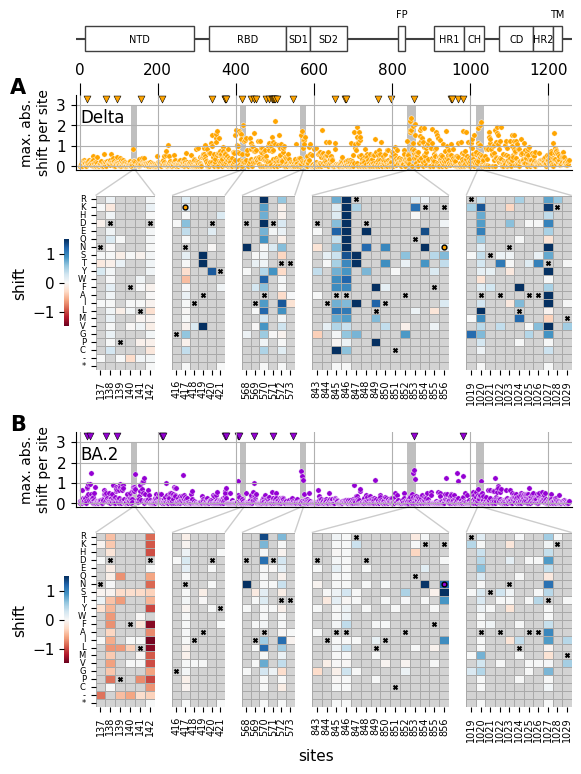

In [114]:
## xlabel = sites
## captilaization
# add sites to the second heatmap
## indicate deletions along with N.I.S (check to make sure you're capturing all nis)

# make interactive heatmap and send link to where folks can find that.

saveas = "shift_by_site_heatmap_zoom"

site_ranges = {
    "zoom1" : [137, 142],
    "zoom2" : [416, 421],
    "zoom3" : [568, 573],
    "zoom4" : [843, 856],
    "zoom5" : [1019, 1029]
}

# heatmap ax width ratios
width_ratios = [(end-start) for key, (start, end) in site_ranges.items()]

# make the first one a little bigger for the color bar
width_ratios[0] += width_ratios[0] * 0.5


# Plot domain architecture in primary sequence
# based on structure papers (Gobeil et al., 2022, Molecular Cell)
# (Duan et al., 2020, Frotiers in Immunology)
domain_dict = {
    'NTD' : [13, 293],
    'RBD' : [330, 528],
    'SD1' : [528, 590],
    'SD2' : [590, 685],
    'FP' : [815, 834],
    'HR1' : [907, 985],
    'CH' : [985, 1035],
    'CD' : [1075, 1162],
    'HR2' : [1162, 1211],
    'TM' : [1211, 1234],
}

sort_order = [
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","-","*",
]

fig = plt.figure( figsize=[6.4, 9])
axs = fig.subplot_mosaic(
    [
        ["Annotation"]*5,
        ["Delta"]*5,
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        ["."]*5,
        ["BA2"]*5,
        [f"{k}_BA2" for k in list(site_ranges.keys())],
        [f"{k}_BA2" for k in list(site_ranges.keys())]
    ],
    
    height_ratios=[
        1.5, 
        2, 
        2, 
        2,
        0.3,
        2,
        2, 
        2
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
    width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)

# derived from
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_zoom_effect.html
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect03(ax1, ax2, xmin, xmax, **kwargs):

    mybbox1 = ax1.bbox
    
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

#############
# sitewise
#############


pal = sns.color_palette('colorblind')
cs = ['darkviolet', 'orange']
cs = {
    'BA2' : 'darkviolet', 
    'Delta' : 'orange'
}


# Plot per-site metric
metric_prefix = 'max_abs_S_' # 'delta_bind_S_' # 
# metric_prefix = 'sum_S_' # 'delta_bind_S_' # 
for (i, homolog) in enumerate(['BA2', 'Delta']):
    
    sns.scatterplot(
        x='sites', 
        y=f'{metric_prefix}{homolog}',
        data=shifts_by_site, 
        s=15,
        ax=axs[homolog], 
        color=cs[homolog],
        label=""
    )
    
    
#     nis = shifts_by_site.query(f"not is_{homolog}_wt")
    nis = site_map.query(f"{homolog} != BA1")
    sns.scatterplot(
        x='sites', 
        y=np.repeat(3.3, len(nis)),
        data=nis, 
        s=25,
        ax=axs[homolog],
        marker='v',
        facecolor=cs[homolog], 
        edgecolor="black"
    )

    
    
    axs[homolog].set_ylabel("max($|S_{m \in site}|$)", size=10)
    axs[homolog].grid()
    axs[homolog].set(
        xlim=[-10,1260],
        yticks=[0,1,2,3],
#         ylabel=homolog,/
    )
    sns.despine(ax=axs[homolog])
    
    axs[homolog].tick_params(
        axis='x', 
        bottom=False,
        labelbottom=False,
        labeltop=True if homolog == "Delta" else False,
        top=True if homolog == "Delta" else False,
        size=9
    )
    axs[homolog].set_xlabel(None)
#     axs[homolog].set_ylabel("max($|S_{m \in site}|$)", size=10)
    axs[homolog].set_ylabel("max. abs.\nshift per site", size=10)


axs["BA2"]._shared_axes['x'].join(axs["BA2"], axs["Delta"])

plot_rectangles = True
for zoom, site_range in site_ranges.items():
    if not plot_rectangles:
        continue
    (site_i, site_j) = site_range
    for (i, homolog) in enumerate(['BA2', 'Delta']):
        rect = patches.Rectangle(
            (site_i-5, -0.2), site_j-site_i+11, 3.2,
            edgecolor='none', facecolor='0.75', zorder=0
        )
        axs[homolog].add_patch(rect)
        
        
#############
# Annotation
#############

for (domain, (start, end)) in domain_dict.items():
    rectangle = patches.Rectangle((start, 1), end-start, 2, edgecolor='0.25', facecolor='white')
    axs["Annotation"].add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry - 0.05 + rectangle.get_height()/2.0
    if domain in ['FP', 'TM']:
        cy += 2
    axs["Annotation"].annotate(
        domain, (cx, cy), color='black', ha='center', va='center',
        fontsize=7
    )

axs["Annotation"].set(ylim=[-0.5,4], yticks=[])
sns.despine(left=True, bottom=True, ax=axs["Annotation"])

axs["Annotation"].sharex(axs["BA2"])
axs["Annotation"].axhline(2, c='0.25', zorder=0)
axs["Annotation"].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

#############
# Heatmap
#############

for (i, homolog) in enumerate(['Delta', 'BA2']):
    
    df_shifts_wide = mut_df_replicates.pivot(
        index='muts', 
        columns='sites', 
        values=f'avg_S_{homolog}'
    ).loc[sort_order, :]

    for zoom, (start, end) in site_ranges.items():
        
        iter_ax = axs[f"{zoom}_{homolog}"]
        iter_ax.set_facecolor("lightgrey")
        sites = [s for s in list(range(start, end+1)) if s in df_shifts_wide.columns]
        
        sns.heatmap(
            df_shifts_wide.loc[:, sites], 
            cbar=True if zoom == "zoom1" else False,
            cbar_kws={
                "shrink": 0.5, 
                "location":'left',
                'anchor': (-1.5, 0.5),
                'label' : 'shift'
            },
            ax = iter_ax,
            linewidth=.5, 
            linecolor="darkgrey",
            center=0,
            cmap='RdBu',
            vmin=-1.5,
            vmax=1.5,
            xticklabels=False,
            yticklabels=False,
        )

        for i, site in enumerate(sites):
            for j, mut in enumerate(sort_order):
                
                is_ref_wt = True if mut == site_map.loc[site,"BA1"] else False
                if is_ref_wt:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="x", 
                        s=8, 
                        c="black"
                    )
#                 hom = homolog if homolog == "Delta" else "Omicron_BA2"
                is_nis = (
                    True 
                    if mut ==  site_map.loc[site,homolog] and
                    mut !=  site_map.loc[site,"BA1"]
                    else False
                )
                
                if is_nis:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="o", 
                        s=12, 
                        facecolors=cs[homolog],
                        edgecolors="black"
                    )

        if zoom != "zoom1":
            axs[f"{zoom}_{homolog}"].tick_params(axis='y', left=False, labelleft=False)
            sns.despine(left=True, bottom=True, ax=axs[f"{zoom}_{homolog}"])  
        else:
            axs[f"{zoom}_{homolog}"].set_yticks(
                [s+0.5 for s in range(len(sort_order))],
                labels=sort_order, 
                va="center",
                size=6
            )
            
        axs[f"{zoom}_{homolog}"].set_ylabel(None)
            
        if homolog != "Delta":
#             axs[f"{zoom}_{homolog}"].tick_params(axis='x', bottom=False, labelbottom=False) 
#         else:
            axs[f"{zoom}_{homolog}"].sharex(axs[f"{zoom}_Delta"])
        axs[f"{zoom}_{homolog}"].set_xticks(
            [s+0.5 for s in range(len(sites))],
             labels=sites, 
             ha="center",
            rotation=90,
            size=7
        )
        axs[f"{zoom}_{homolog}"].set_xlabel(None)

for zoom, (start, end) in site_ranges.items():
    for homolog in ['Delta', 'BA2']:
        zoom_effect03(axs[f"{zoom}_{homolog}"], axs[homolog], start, end, alpha= 0.2)

fig.text(
    0.5, 0.05, 'sites',
    ha='center'
)

axs["Delta"].text(
    -0.1, 1.10, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta"].transAxes
)
axs["Delta"].text(
    0.01, .82, 
    f"Delta", 
    ha="left", va="top", 
    size=12,
    transform=axs["Delta"].transAxes
)

axs["BA2"].text(
    -0.1, 1.10, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["BA2"].transAxes
)
axs["BA2"].text(
    0.01, .82, 
    f"BA.2", 
    ha="left", va="top", 
    size=12,
    transform=axs["BA2"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Interactive heatmap

In [115]:
chart = model.mut_shift_plot()
chart.save(f"{OUTDIR}/interactive_chart_w_beta.html")
chart = model.mut_shift_plot(include_beta=False)
chart.save(f"{OUTDIR}/interactive_chart_wo_beta.html")
chart

alt.VConcatChart(...)

## Sitewise Sum of Shifts by Site

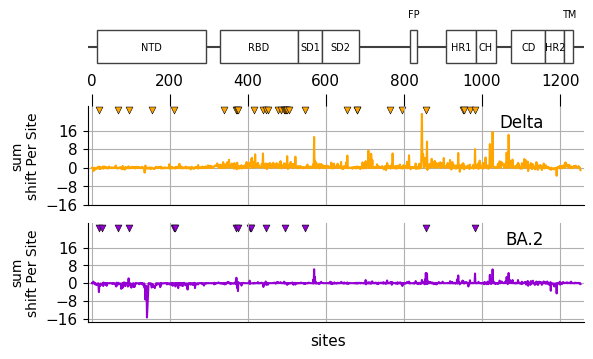

In [116]:
## xlabel

saveas = "sum_shift_by_site"

# Plot domain architecture in primary sequence
# based on structure papers (Gobeil et al., 2022, Molecular Cell)
# (Duan et al., 2020, Frotiers in Immunology)
domain_dict = {
    'NTD' : [13, 293],
    'RBD' : [330, 528],
    'SD1' : [528, 590],
    'SD2' : [590, 685],
    'FP' : [815, 834],
    'HR1' : [907, 985],
    'CH' : [985, 1035],
    'CD' : [1075, 1162],
    'HR2' : [1162, 1211],
    'TM' : [1211, 1234],
}

fig = plt.figure(figsize=[6.4, 4])
axs = fig.subplot_mosaic(
    [
        ["Annotation"],
        ["Delta"],
        ["BA2"]
    ],
    
    height_ratios=[
        1.5, 
        2, 
        2,
    ],
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.2,
    }
)


#############
# sitewise
#############

pal = sns.color_palette('colorblind')
cs = ['darkviolet', 'orange']
cs = {
    'BA2' : 'darkviolet', 
    'Delta' : 'orange'
}

# Plot per-site metric
# metric_prefix = 'max_abs_S_' # 'delta_bind_S_' # 
metric_prefix = 'sum_S_' # 'delta_bind_S_' # 
for (i, homolog) in enumerate(['BA2', 'Delta']):
    
    sns.lineplot(
        x='sites', 
        y=f'{metric_prefix}{homolog}',
        data=shifts_by_site,
        ax=axs[homolog], 
        color=cs[homolog],
        label=""
    )
    
    nis = site_map.query(f"{homolog} != BA1")
    sns.scatterplot(
        x='sites', 
        y=np.repeat(25, len(nis)),
        data=nis, 
        s=25,
        ax=axs[homolog],
        marker='v',
        facecolor=cs[homolog], 
        edgecolor="black"
    )
    
#     nis = shifts_by_site.query(f"not is_{homolog}_wt")
#     sns.scatterplot(
#         x='sites', 
#         y=np.repeat(25, len(nis)),
#         data=nis, 
#         s=25,
#         ax=axs[homolog],
#         marker='v',
#         facecolor=cs[homolog], 
#         edgecolor="black"
#     )

    axs[homolog].grid()
    axs[homolog].set(
        xlim=[-10,1260],
        yticks=np.linspace(-16, 16, 5)
    )
    sns.despine(ax=axs[homolog])
    
    axs[homolog].tick_params(
        axis='x', 
        labelbottom=False,
        bottom=False,
        labeltop=True if homolog == "Delta" else False,
        top=True if homolog == "Delta" else False,
        size=9
    )
    axs[homolog].set_xlabel(None)
    axs[homolog].set_ylabel("sum\nshift Per Site", size=10)
    
axs["BA2"]._shared_axes['x'].join(axs["BA2"], axs["Delta"])
        
#############
# Annotation
#############

for (domain, (start, end)) in domain_dict.items():
    rectangle = patches.Rectangle((start, 1), end-start, 2, edgecolor='0.25', facecolor='white')
    axs["Annotation"].add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry - 0.05 + rectangle.get_height()/2.0
    if domain in ['FP', 'TM']:
        cy += 2
    axs["Annotation"].annotate(
        domain, (cx, cy), color='black', ha='center', va='center',
        fontsize=7
    )

axs["Annotation"].set(ylim=[-0.5,4], yticks=[])
sns.despine(left=True, bottom=True, ax=axs["Annotation"])

axs["Annotation"].sharex(axs["BA2"])
axs["Annotation"].axhline(2, c='0.25', zorder=0)
axs["Annotation"].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

fig.text(
    0.5, 0.05, 'sites',
    ha='center'
)

axs["Delta"].text(
    .92, .92, 
    f"Delta", 
    ha="right", va="top", 
    size=12,
    transform=axs["Delta"].transAxes
)

axs["BA2"].text(
    .92, .92, 
    f"BA.2", 
    ha="right", va="top", 
    size=12,
    transform=axs["BA2"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Validation Mutations Shift V Titer fold change

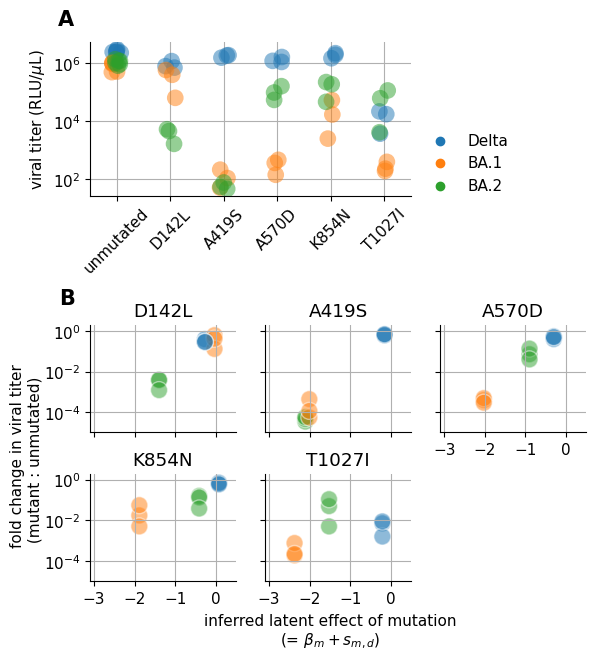

In [119]:
# WT -> unmutated
# shift the xlabel up a bit
# change panel B tick labels to be whole numbers 0, -1, -2

saveas="validation_titer_fold_change"

row1 = ['titer', 'titer', '.']
row2 = ['D142L', 'A419S', 'A570D'] 
row3 = ['K854N', 'T1027I', 'legend']
empty_row = ["."] * 3

fig = plt.figure( figsize=[6.4, 7])
axs = fig.subplot_mosaic(
    [row1, empty_row, row2, row3],
    height_ratios=[
        1, 0.3, 0.7, 0.7
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
#     width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)


#############
# TITERS
#############

# Read in data
titers_df = pd.read_csv('../data/viral_titers.csv')
titers_df.rename(
    columns={'RLUperuL':'titer', 'background':'homolog'},
    inplace=True
)

# Add a column giving the replicate and mutation
titers_df['replicate'] = titers_df['virus'].apply(lambda x: x[-1])
titers_df['mutation'] = titers_df['virus'].str.extract(r'_(\S+)_')
titers_df['mutation'].fillna('unmutated', inplace=True)
titers_df['mutation'].replace('142L', 'D142L', inplace=True)

# Plot data for a given mutation
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
#mutation = 'A570D'
homologs = ['Delta', 'BA.1', 'BA.2']
replicates = ['1', '2', '3']
# plt.figure(figsize=[7,4])
xticklabels = ['unmutated'] + validation_mutations
pal = sns.color_palette('colorblind')
hex_codes = pal.as_hex()
for (i, homolog) in enumerate(homologs):
    
    data = titers_df[(titers_df['homolog'] == homolog)]
    
    sns.stripplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels, s=12, alpha=0.5,
        hue='homolog', hue_order=['Delta', 'BA.1', 'BA.2'],
    )
    sns.boxplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels,
        showfliers=False, showbox=False, showcaps=False,
        medianprops={'visible': False}, #dict(color=hex_codes[i]),
        whiskerprops={'visible': False},
    )

handles, labels = axs['titer'].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs['titer'].legend(by_label.values(), by_label.keys(), bbox_to_anchor=[1,0.5])

axs['titer'].set_yscale('log')
axs['titer'].set_yticks([1e2, 1e4, 1e6])
axs['titer'].set_xticklabels(axs['titer'].get_xticklabels(), rotation = 45)
axs['titer'].set_ylabel(r'viral titer (RLU/$\mu$L)')
axs['titer'].set_xlabel('')
axs['titer'].grid()
sns.despine(ax = axs['titer'])


#############
# FOLD CHANGE
#############

replicate_models = models.query("λ_lasso_shift == 5e-5")
fit_dict = {row.replicate:row[model_name] for _, row in replicate_models.iterrows()}
mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="inner")

rep0 = fit_dict[0]
for homolog in rep0.data.conditions:
    if homolog == rep0.data.reference:

        mut_df[f"β_{homolog}"] = mut_df.avg_β
    else:

        mut_df[f"β_{homolog}"] = mut_df.avg_β + mut_df[f"avg_S_{homolog}"]

mut_df.reset_index(inplace=True)

# Read in data
val_df = pd.read_csv('../data/spike_validation_data.csv')

# Restructure the data
val_dict = {
    key : []
    for key in [
        'mutation', 'fold_change', 'homolog', 'replicate',
        'predicted_beta'
    ]
}
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
for i, row in val_df.iterrows():
    for mutation in validation_mutations:
        homolog = row['background'].replace('.', '')
        homolog = "Omicron_" + homolog if "BA" in homolog else homolog

        val_dict['mutation'].append(mutation)
        val_dict['fold_change'].append(row[mutation])
        val_dict['homolog'].append(homolog)
        val_dict['replicate'].append(row['replicate'])

        predicted_beta = float(mut_df[
            mut_df['mutation'] == mutation
        ][f'β_{homolog}'].values[0])
        val_dict['predicted_beta'].append(predicted_beta)

val_df = pd.DataFrame(val_dict)
val_df['site'] = val_df['mutation'].apply(lambda x: int(x[1:-1]))
val_df['homolog'].replace('Omicron_BA1', 'BA.1', inplace=True)
val_df['homolog'].replace('Omicron_BA2', 'BA.2', inplace=True)
val_df.sort_values('site', inplace=True)

for (i, mutation) in enumerate(validation_mutations):
    data = val_df[val_df['mutation'] == mutation]
    iter_ax = axs[mutation]
    sns.scatterplot(
        x='predicted_beta', y='fold_change', data=data,
        hue='homolog', ax=iter_ax, s=150, alpha=0.5,
        hue_order=['Delta', 'BA.1', 'BA.2']
    )
    iter_ax.set(
        title=mutation, xlabel='', ylabel='',
        yscale='log', ylim=[1e-5,2], yticks=[1, 1e-2, 1e-4],
        xlim=[-3.1, 0.5], xticks=[-3, -2, -1, 0]
    )
    iter_ax.grid()
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    if mutation in ['D142L', 'A419S']:
        iter_ax.tick_params(axis="x", labelbottom=False)
    
    if mutation not in ['D142L', 'K854N']:
        iter_ax.tick_params(axis="y", labelleft=False)

fig.text(
    0.5, 0.02, 'inferred latent effect of mutation\n(= $β_m + s_{m,d}$)',
    ha='center'
)
fig.text(
    0.000, 0.29, 'fold change in viral titer\n (mutant : unmutated)',
    va='center', rotation='vertical'
)
axs["legend"].set_axis_off()

axs["titer"].text(
    -0.05, 1.15, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["titer"].transAxes
)
axs["D142L"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["D142L"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()